In [48]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import random
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set random seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [49]:
# reading the data into a dataframe and making a copy
df_pd = pd.read_csv("Dataset/bank-additional/bank-additional/bank-additional-full.csv", sep=";")
df = df_pd.copy()

In [50]:
# brief overview of the dataset
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Data Cleaning

1) Remove Duplicates

In [51]:
# Check for duplicates
duplicates = df.duplicated()
print(duplicates.sum())

12


In [52]:
# Remove duplicates
df = df.drop_duplicates()
df.shape # reduced to 41176 from 41188

(41176, 21)

2) Check and fix structural errors

In [53]:
# check for null values
df.isna().sum()

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


In [54]:
# check unique values of categorical columns to identify structural errors
for x in df.select_dtypes("object").columns:
    print(x)
    print(df[x].unique())
    print(" ")

job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
 
marital
['married' 'single' 'divorced' 'unknown']
 
education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
 
default
['no' 'unknown' 'yes']
 
housing
['no' 'yes' 'unknown']
 
loan
['no' 'yes' 'unknown']
 
contact
['telephone' 'cellular']
 
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
 
day_of_week
['mon' 'tue' 'wed' 'thu' 'fri']
 
poutcome
['nonexistent' 'failure' 'success']
 
y
['no' 'yes']
 


No structural errors in the categorical features. The "unknown" label of some features and "nonexistent" label of poutcome will be handled later.

3) Filtering outliers

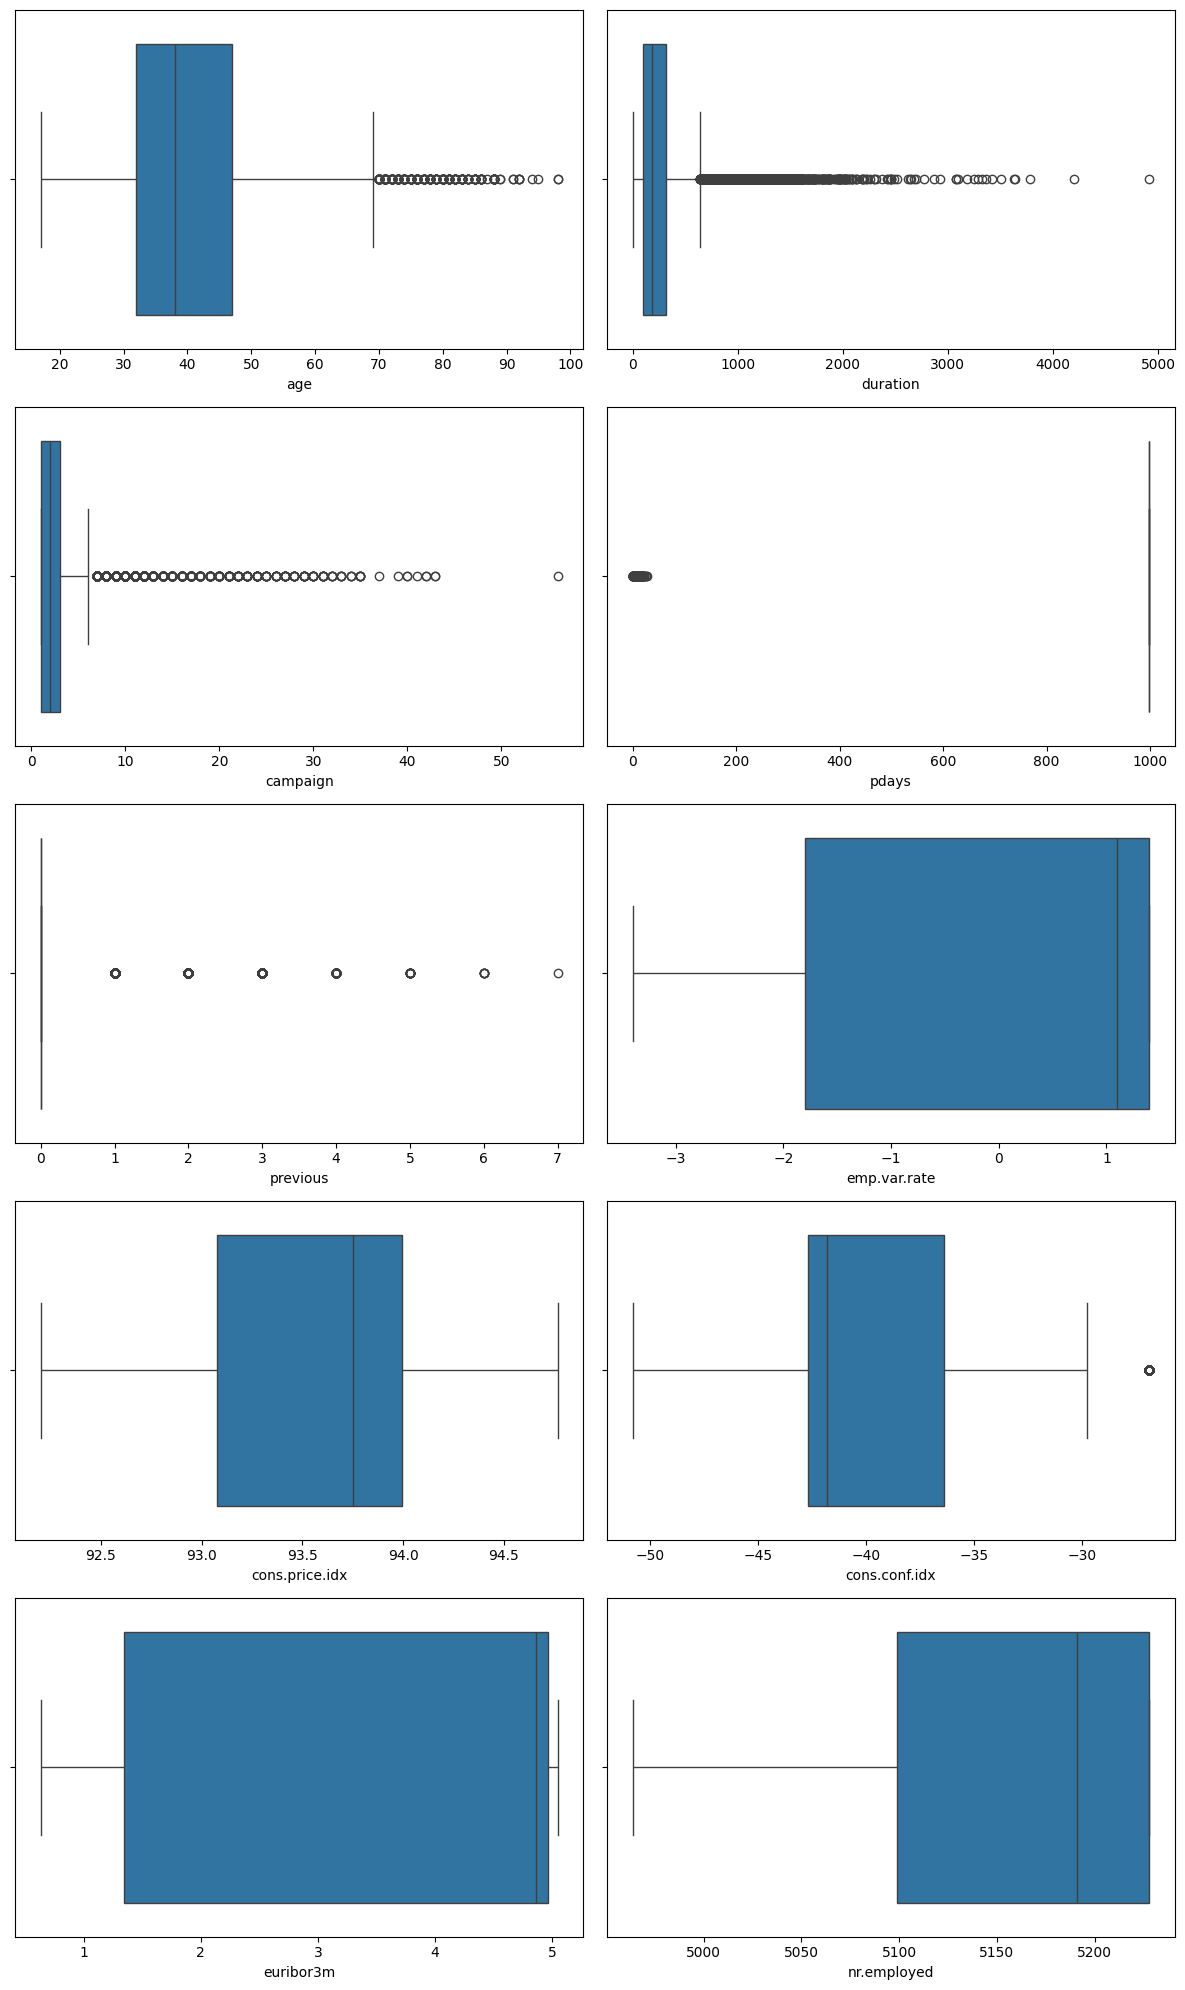

In [55]:
# check for outliers in numerical columns by plotting boxplots
numerical_columns = df.select_dtypes("number").columns
n_cols = 2
n_rows = len(numerical_columns) // n_cols

# Set up the figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()

# Plot boxplots
for i, col in enumerate(numerical_columns):
    sns.boxplot(x=df[col], ax=axes[i])

plt.tight_layout()
plt.show()

Outliers can be seen in age, duration, campaign, pdays, previous, cons.conf.idx

In [56]:
# Function to get outliers based on IQR
def get_outliers(series):
    Q1 = series.quantile(0.25)  # First quartile
    Q3 = series.quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile range
    # calculating upper and lower bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Count outliers
    outliers = ((series < lower_bound) | (series > upper_bound)).sum()
    return lower_bound, upper_bound, outliers

In [57]:
print("Number of outliers in age:",get_outliers(df.age)[2])
print("Percentage of outliers:",get_outliers(df.age)[2]*100/df.shape[0])
print("Maximum age: ", df.age.max())

Number of outliers in age: 468
Percentage of outliers: 1.1365844181076354
Maximum age:  98


Eventhough 468 values are outliers, these values are reasonable and valid. Therefore these values will be kept as they are.

In [58]:
# most common value in pdays feature
print("Percentage of clients not contacted previously: ",df[df['pdays'] == 999]['pdays'].shape[0]*100/df.shape[0])

Percentage of clients not contacted previously:  96.32067223625413


In [59]:
# most common value in previous feature
print("Percentage of zero previous contacts : ",df[df['previous'] == 0]['previous'].shape[0]*100/df.shape[0])

Percentage of zero previous contacts :  86.33912959005245


Further investigation reveals that clients not previously contacted according to 'pdays' has previous contacts according to 'previous'.

In [60]:
# getting the clients that have not been contacted previously using 'pdays' == 999,
# checking the 'previous' value counts of those clients
df[df['pdays'] == 999]['previous'].value_counts()

,count
previous,
0,35551
1,3696
2,349
3,50
4,12
5,2
6,1


The inconsistent rows will be removed to maintain data quality.

In [61]:
# removing rows with 'previous' > 0 from rows of 'pdays' == 999
df = df[~((df['pdays'] == 999) & (df['previous'] > 0))]

In [62]:
df.pdays.value_counts()/df.shape[0]*100

,count
pdays,
999,95.912696
3,1.184374
6,1.111531
4,0.318351
9,0.172665
2,0.164571
7,0.161873
12,0.156478
10,0.140290


'pdays' will be removed from the dataset as there is very little variation and not much information can be gained from it.

In [63]:
df.drop(columns = 'pdays', inplace = True)

<ipython-input-63-c55254e8d955>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns = 'pdays', inplace = True)


For clients who were not contacted in previous marketing campaigns (previous = 0), the outcome of the previous campaign is consistently labeled as "nonexistent." Therefore the "nonexistent" label is a valid label.

In [64]:
print("Value counts of poutcome\n",df.poutcome.value_counts(), "\n")

print("Clients with 0 previous campaign contacts\n",df[df['previous'] == 0]['poutcome'].value_counts())

Value counts of poutcome
 poutcome
nonexistent    35551
success         1373
failure          142
Name: count, dtype: int64 

Clients with 0 previous campaign contacts
 poutcome
nonexistent    35551
Name: count, dtype: int64


In [65]:
df.previous.value_counts()/df.shape[0]*100

,count
previous,
0,95.912696
1,2.333675
2,1.092646
3,0.447850
4,0.156478
5,0.043166
6,0.010792
7,0.002698


'previous' will be removed from the dataset as there is very little variation and not much information can be gained from it.

In [66]:
df.drop(columns = 'previous', inplace = True)

In [67]:
print("Number of outliers in cons.conf.idx:",get_outliers(df["cons.conf.idx"])[2])
print("Percentage of outliers in cons.conf.idx:", get_outliers(df["cons.conf.idx"])[2]*100/df.shape[0])
print("Maximum cons.conf.idx value: ", df["cons.conf.idx"].max())
print("Upper bound: ", get_outliers(df["cons.conf.idx"])[1])

Number of outliers in cons.conf.idx: 348
Percentage of outliers in cons.conf.idx: 0.9388658069389737
Maximum cons.conf.idx value:  -26.9
Upper bound:  -26.949999999999992


In [68]:
# checking the outlier values
df[df["cons.conf.idx"] > get_outliers(df["cons.conf.idx"])[1]]["cons.conf.idx"].value_counts()

,count
cons.conf.idx,
-26.9,348


All the outliers have the value of -26.9 and they are all close to the upper bound(-26.9499999). Therefore it is not necesssary to handle those outliers.

In [69]:
# The duration is not known before a call is performed, therefore it is not used for model training
df.drop(columns = ["duration"], inplace = True)

Campaign indicates the number of contacts performed during this campaign for a particular client.
The maximum value of campaign is 56 and the values above 6 are taken as outliers. These values cannot be dropped as they might not be erroneous. It is hard to reach an exact decision without more information about the feature, therefore by considering the boxplot the outliers were imputed with the median.

In [70]:
print("Number of outliers in campaign :",get_outliers(df.campaign)[2])
print("Percentage of outliers in campaign:", get_outliers(df.campaign)[2]*100/df.shape[0])
print("Maximum campaign value: ", df.campaign.max())
print("Upper bound: ", get_outliers(df.campaign)[1])

Number of outliers in campaign : 2318
Percentage of outliers in campaign: 6.253709599093509
Maximum campaign value:  56
Upper bound:  6.0


In [71]:
median = np.median(df['campaign'])
lower_bound, upper_bound, outliers = get_outliers(df['campaign'])

# Replace outliers in the 'campaign' column with the median
df.loc[(df['campaign'] < lower_bound) | (df['campaign'] > upper_bound), 'campaign'] = median

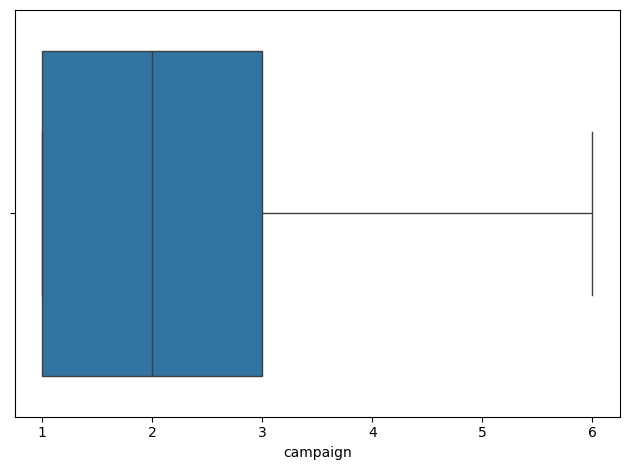

In [72]:
# outliers handled
sns.boxplot(x=df["campaign"])
plt.tight_layout()
plt.show()

4) Handle missing data

In [73]:
# Visualize the "unknown" value percentage of each column
unknownDF = pd.DataFrame({"Column": pd.Series(dtype="str"), "Unknown_Percentage": pd.Series(dtype="float")})
for x in df.columns:
    numberUnknown = df[x][df[x] == 'unknown'].shape[0]
    unknownProportion = numberUnknown/df.shape[0]
    # only non zero percentages are displayed
    if unknownProportion != 0:
        new_row = pd.DataFrame({"Column":[x], "Unknown_Percentage":[unknownProportion*100]})
        unknownDF = pd.concat([unknownDF, new_row], ignore_index=True)
unknownDF

,Column,Unknown_Percentage
0,job,0.844440
1,marital,0.180759
2,education,4.203313
3,default,21.812443
4,housing,2.387633
5,loan,2.387633


In [74]:
df.default.value_counts()

,count
default,
no,28979
unknown,8085
yes,2


Almost all values of the 'default' feature is either "no" or "unknown". This column does not give much information so it will be dropped.

In [75]:
# drop default column
df.drop(columns = ['default'], inplace = True)

The remaining categorical columns contain "unknown" labels in less than 5% of their values. As a result, these "unknown" labels will be replaced with the mode of each respective column.

In [76]:
import pandas as pd
import numpy as np

columns = ['job', 'marital', 'education', 'housing', 'loan']

# Manually replace 'unknown' with the mode of each column
for column in columns:
    mode_value = df[column].mode()[0]  # Get the mode (most frequent value) of the column
    df[column] = df[column].replace('unknown', mode_value)

Identifying class imbalance

In [77]:
# class imbalance
class_counts = df['y'].value_counts()

# Display the counts and the ratio
print("Class counts:")
print(class_counts)
print(f"\nClass imbalance ratio: {class_counts.iloc[0]/df.shape[0]:.3f}: {class_counts.iloc[1]/df.shape[0]:.3f}")

Class counts:
y
no     32959
yes     4107
Name: count, dtype: int64

Class imbalance ratio: 0.889: 0.111


This class imbalance will be handled by using several techniques.

In [78]:
# Initialize StandardScaler
scaler = StandardScaler()

# Apply scaler only to numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
print(numerical_cols)

df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

df.head()

Index(['age', 'campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed'],
      dtype='object')


,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,1.550150,housemaid,married,basic.4y,no,no,telephone,may,mon,-0.849526,nonexistent,0.545562,0.641367,0.864237,0.616821,0.231688,no
1,1.647237,services,married,high.school,no,no,telephone,may,mon,-0.849526,nonexistent,0.545562,0.641367,0.864237,0.616821,0.231688,no
2,-0.294504,services,married,high.school,yes,no,telephone,may,mon,-0.849526,nonexistent,0.545562,0.641367,0.864237,0.616821,0.231688,no
3,-0.003243,admin.,married,basic.6y,no,no,telephone,may,mon,-0.849526,nonexistent,0.545562,0.641367,0.864237,0.616821,0.231688,no
4,1.550150,services,married,high.school,no,yes,telephone,may,mon,-0.849526,nonexistent,0.545562,0.641367,0.864237,0.616821,0.231688,no


In [79]:
# Encode target
label_encoder = LabelEncoder()
df.y = label_encoder.fit_transform(df.y)

In [80]:
# one hot encoding for categorical features
df = pd.get_dummies(df, columns=['job', 'marital', 'education', 'housing', 'loan', 'contact',
       'month','day_of_week','poutcome'])

In [81]:
# final shape of the dataframe
df.shape

(37066, 53)

In [82]:
# Splitting the dataset into target variable and predictive features
y = df.y
X = df.drop(columns = ['y'])

Model validation technique used will be stratified K fold cross validation as the dataset is imbalanced.

Class imbalance will be handled with different techniques when training models,


1.   Random Oversampling
2.   Random Undersampling
3.   SMOTE



Random Oversampling

1854/1854 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


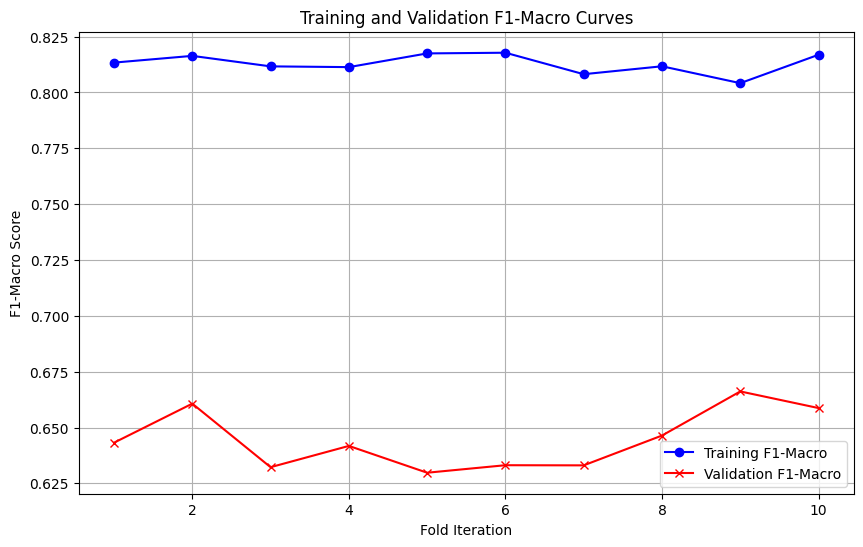

Mean Training F1-Macro: 0.813
Mean Validation F1-Macro: 0.645


In [83]:
# Define the model
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'), # hidden layer
        tf.keras.layers.Dense(32, activation='relu'),  # hidden layer
        tf.keras.layers.Dense(1, activation='sigmoid')  # output layer
    ])

    model.compile(optimizer='adam',loss='binary_crossentropy')

    return model

# Define Repeated Stratified K-Fold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)

# Store training and validation scores
train_scores = []
val_scores = []

# Calculate training and validation performance for each fold
for train_idx, val_idx in cv.split(X, y):
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Apply RandomOverSampler to balance the class distribution in the training data
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    # Create a new model for each fold
    model = create_model()

    # Fit model on resampled training data
    model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=64, verbose=0)

    # Evaluate on training data
    y_train_pred = model.predict(X_train_resampled)
    y_train_pred = (y_train_pred > 0.5).astype(int)  # probabilities to binary
    train_f1 = f1_score(y_train_resampled, y_train_pred, average='macro')
    train_scores.append(train_f1)

    # Evaluate on validation data
    y_val_pred = model.predict(X_val)
    y_val_pred = (y_val_pred > 0.5).astype(int)  # probabilities to binary
    val_f1 = f1_score(y_val, y_val_pred, average='macro')
    val_scores.append(val_f1)


train_scores = np.array(train_scores)
val_scores = np.array(val_scores)

# Plotting the curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_scores) + 1), train_scores, label="Training F1-Macro", color='blue', linestyle='-', marker='o')
plt.plot(range(1, len(val_scores) + 1), val_scores, label="Validation F1-Macro", color='red', linestyle='-', marker='x')

plt.title('Training and Validation F1-Macro Curves')
plt.xlabel('Fold Iteration')
plt.ylabel('F1-Macro Score')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('NNOS1.png')
plt.show()

# Calculate and print the mean F1-macro scores
print(f'Mean Training F1-Macro: {train_scores.mean():.3f}')
print(f'Mean Validation F1-Macro: {val_scores.mean():.3f}')

In [84]:
# Install if necessary
!pip install scikeras

In [85]:
# Define a function to create the ANN model
def build_model(dropout_rate, learning_rate, neurons):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(neurons, activation='relu'),  # Hidden layer
        tf.keras.layers.Dropout(dropout_rate),  # dropout layer
        tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer
        tf.keras.layers.Dropout(0.2),  # Dropout layer
        tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy')
    return model

In [86]:
# Define scoring for F1-macro
scoring = make_scorer(f1_score, average='macro')

# Define Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


model = KerasClassifier(model=build_model, epochs=10, batch_size=128, verbose=0, dropout_rate=0.2, learning_rate = 0.01, neurons = 64)

# hyperparameter grid
dropout_rate = [0.2, 0.3]
learning_rate = [0.01, 0.1]
neurons = [64, 128, 256]
param_grid = dict(model__dropout_rate=dropout_rate, model__learning_rate = learning_rate, model__neurons = neurons)


# Set up the pipeline with RandomOverSampler and the Keras model
pipeline = Pipeline(steps=[('ros', RandomOverSampler(random_state=42)),
                           ('model', model)])

# grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=cv, return_train_score=True, scoring=scoring)
grid_result = grid_search.fit(X, y)

# results: training and validation F1 scores
results = pd.DataFrame(grid_result.cv_results_)

# Display results
resultsDF = pd.DataFrame(results[['params', 'mean_train_score', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).iloc[0])
resultsDF

,11
params,"{'model__dropout_rate': 0.3, 'model__learning_..."
mean_train_score,0.715516
mean_test_score,0.712105


348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Confusion Matrix:


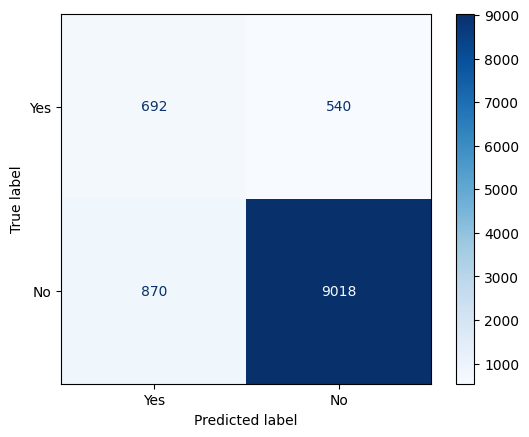


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      9888
           1       0.44      0.56      0.50      1232

    accuracy                           0.87     11120
   macro avg       0.69      0.74      0.71     11120
weighted avg       0.89      0.87      0.88     11120

348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


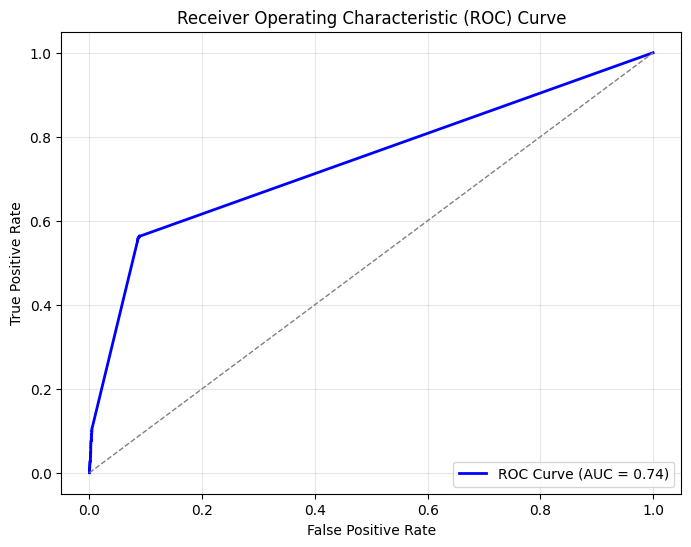

In [87]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply RandomOverSampler to the training set only
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# best parameters from the grid search
best_model = build_model(0.3, 0.1, 256)

best_model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=128, verbose=0)

# Generate predictions on the test set
y_pred = best_model.predict(X_test)  # For probabilities
y_pred_classes = (y_pred > 0.5).astype(int)  # probabilities to class labels

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes, labels=[1, 0])

# Display confusion matrix
print("\nConfusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Yes", "No"])
disp.plot(cmap=plt.cm.Blues)
plt.savefig('NNOSCM.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes,zero_division=1))

# ROC Curve and AUC
y_pred_prob = best_model.predict(X_test).ravel()  # Get predicted probabilities for positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig('NNOSROC.png')
plt.show()

Random Undersampling

231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


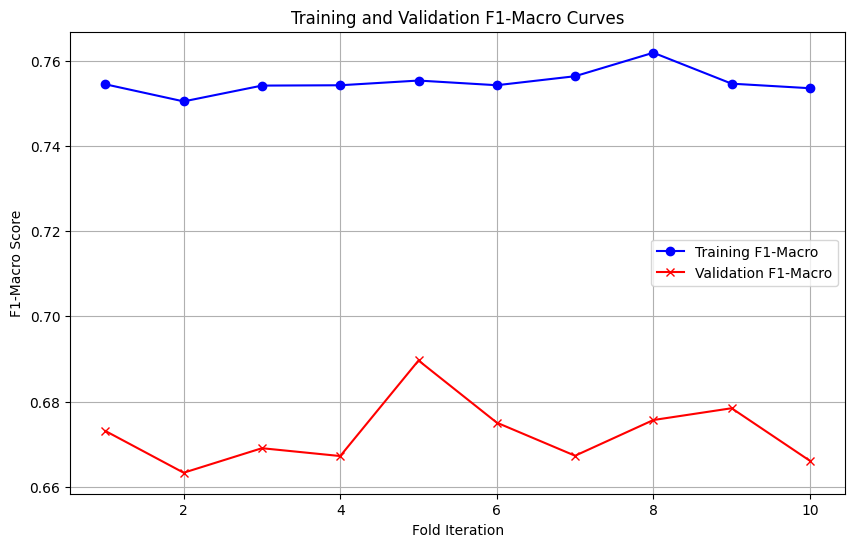

Mean Training F1-Macro: 0.755
Mean Validation F1-Macro: 0.672


In [88]:
# Define the model
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'), # hidden layer
        tf.keras.layers.Dense(32, activation='relu'),  # hidden layer
        tf.keras.layers.Dense(1, activation='sigmoid')  # output layer
    ])

    model.compile(optimizer='adam',loss='binary_crossentropy')

    return model

# Define Repeated Stratified K-Fold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)

# Store training and validation scores
train_scores = []
val_scores = []

# Calculate training and validation performance for each fold
for train_idx, val_idx in cv.split(X, y):
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Apply RandomOverSampler to balance the class distribution in the training data
    rus = RandomUnderSampler(random_state=42)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

    # Create a new model for each fold
    model = create_model()

    # Fit model on resampled training data
    model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=64, verbose=0)

    # Evaluate on training data
    y_train_pred = model.predict(X_train_resampled)
    y_train_pred = (y_train_pred > 0.5).astype(int)  # probabilities to binary
    train_f1 = f1_score(y_train_resampled, y_train_pred, average='macro')
    train_scores.append(train_f1)

    # Evaluate on validation data
    y_val_pred = model.predict(X_val)
    y_val_pred = (y_val_pred > 0.5).astype(int)  # probabilities to binary
    val_f1 = f1_score(y_val, y_val_pred, average='macro')
    val_scores.append(val_f1)


train_scores = np.array(train_scores)
val_scores = np.array(val_scores)

# Plotting the curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_scores) + 1), train_scores, label="Training F1-Macro", color='blue', linestyle='-', marker='o')
plt.plot(range(1, len(val_scores) + 1), val_scores, label="Validation F1-Macro", color='red', linestyle='-', marker='x')

plt.title('Training and Validation F1-Macro Curves')
plt.xlabel('Fold Iteration')
plt.ylabel('F1-Macro Score')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('NNUS1.png')
plt.show()

# Calculate and print the mean F1-macro scores
print(f'Mean Training F1-Macro: {train_scores.mean():.3f}')
print(f'Mean Validation F1-Macro: {val_scores.mean():.3f}')

In [89]:
# Define scoring for F1-macro
scoring = make_scorer(f1_score, average='macro')

# Define Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


model = KerasClassifier(model=build_model, epochs=10, batch_size=128, verbose=0, dropout_rate=0.2, learning_rate = 0.01, neurons = 64)

# hyperparameter grid
dropout_rate = [0.2, 0.3]
learning_rate = [0.01, 0.1]
neurons = [64, 128, 256]
param_grid = dict(model__dropout_rate=dropout_rate, model__learning_rate = learning_rate, model__neurons = neurons)


# Set up the pipeline with RandomOverSampler and the Keras model
pipeline = Pipeline(steps=[('rus', RandomUnderSampler(random_state=42)),
                           ('model', model)])

# grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=cv, return_train_score=True, scoring=scoring)
grid_result = grid_search.fit(X, y)

# results: training and validation F1 scores
results = pd.DataFrame(grid_result.cv_results_)

# Display results
resultsDF = pd.DataFrame(results[['params', 'mean_train_score', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).iloc[0])
resultsDF

,11
params,"{'model__dropout_rate': 0.3, 'model__learning_..."
mean_train_score,0.702378
mean_test_score,0.697737


348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Confusion Matrix:


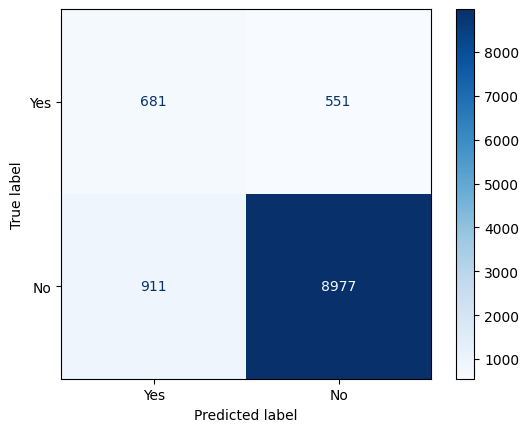


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      9888
           1       0.43      0.55      0.48      1232

    accuracy                           0.87     11120
   macro avg       0.68      0.73      0.70     11120
weighted avg       0.89      0.87      0.88     11120

348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


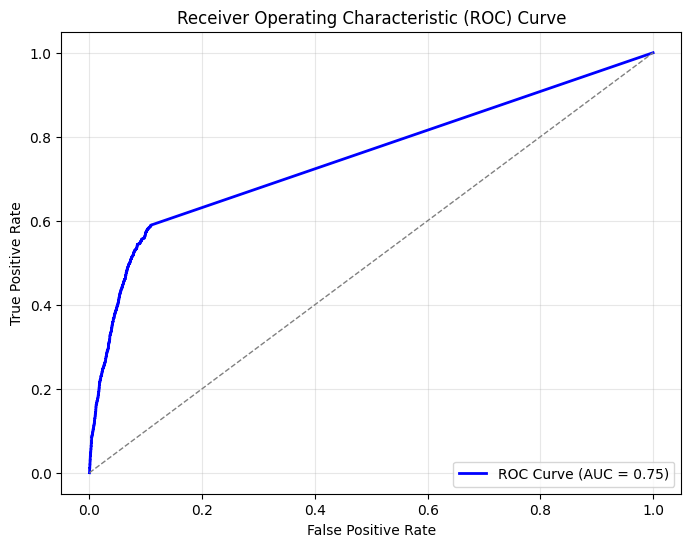

In [90]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply RandomUnderSampler to the training set only
us = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = us.fit_resample(X_train, y_train)


best_model = build_model(0.3, 0.1, 256)

best_model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=128, verbose=0)

# Generate predictions on the test set
y_pred = best_model.predict(X_test)  # For probabilities
y_pred_classes = (y_pred > 0.5).astype(int)  # probabilities to class labels

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes, labels=[1, 0])

# Display confusion matrix
print("\nConfusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Yes", "No"])
disp.plot(cmap=plt.cm.Blues)
plt.savefig('NNUSCM.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes,zero_division=1))

# ROC Curve and AUC
y_pred_prob = best_model.predict(X_test).ravel()  # Get predicted probabilities for positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig('NNUSROC.png')
plt.show()

SMOTE

1854/1854 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1854/1854 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


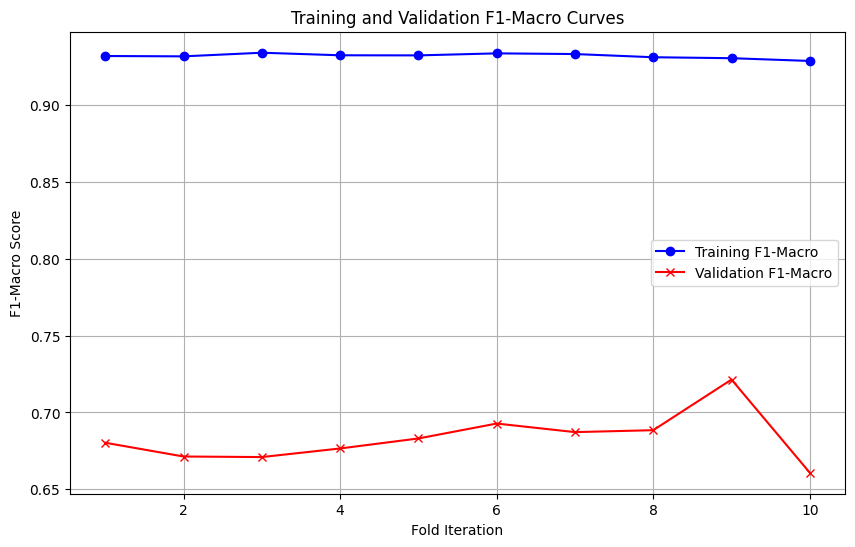

Mean Training F1-Macro: 0.932
Mean Validation F1-Macro: 0.683


In [91]:
# Define the model
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'), # hidden layer
        tf.keras.layers.Dense(32, activation='relu'),  # hidden layer
        tf.keras.layers.Dense(1, activation='sigmoid')  # output layer
    ])

    model.compile(optimizer='adam',loss='binary_crossentropy')

    return model

# Define Repeated Stratified K-Fold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)

# Store training and validation scores
train_scores = []
val_scores = []

# Calculate training and validation performance for each fold
for train_idx, val_idx in cv.split(X, y):
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Apply SMOTE to balance the class distribution in the training data
    sos = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = sos.fit_resample(X_train, y_train)

    # Create a new model for each fold
    model = create_model()

    # Fit model on resampled training data
    model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=64, verbose=0)

    # Evaluate on training data
    y_train_pred = model.predict(X_train_resampled)
    y_train_pred = (y_train_pred > 0.5).astype(int)  # probabilities to binary
    train_f1 = f1_score(y_train_resampled, y_train_pred, average='macro')
    train_scores.append(train_f1)

    # Evaluate on validation data
    y_val_pred = model.predict(X_val)
    y_val_pred = (y_val_pred > 0.5).astype(int)  # probabilities to binary
    val_f1 = f1_score(y_val, y_val_pred, average='macro')
    val_scores.append(val_f1)


train_scores = np.array(train_scores)
val_scores = np.array(val_scores)

# Plotting the curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_scores) + 1), train_scores, label="Training F1-Macro", color='blue', linestyle='-', marker='o')
plt.plot(range(1, len(val_scores) + 1), val_scores, label="Validation F1-Macro", color='red', linestyle='-', marker='x')

plt.title('Training and Validation F1-Macro Curves')
plt.xlabel('Fold Iteration')
plt.ylabel('F1-Macro Score')
plt.legend(loc='best')
plt.grid(True)
plt.savefig('NNSOS1.png')
plt.show()

# Calculate and print the mean F1-macro scores
print(f'Mean Training F1-Macro: {train_scores.mean():.3f}')
print(f'Mean Validation F1-Macro: {val_scores.mean():.3f}')

In [92]:
# Define scoring for F1-macro
scoring = make_scorer(f1_score, average='macro')

# Define Stratified K-Fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


model = KerasClassifier(model=build_model, epochs=10, batch_size=128, verbose=0, dropout_rate=0.2, learning_rate = 0.01, neurons = 64)

# hyperparameter grid
dropout_rate = [0.2, 0.3]
learning_rate = [0.01, 0.1]
neurons = [64, 128, 256]
param_grid = dict(model__dropout_rate=dropout_rate, model__learning_rate = learning_rate, model__neurons = neurons)


# Set up the pipeline with SMOTE and the Keras model
pipeline = Pipeline(steps=[('sos', SMOTE(random_state=42)),
                           ('model', model)])

# grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, n_jobs=-1, cv=cv, return_train_score=True, scoring=scoring)
grid_result = grid_search.fit(X, y)

# results: training and validation F1 scores
results = pd.DataFrame(grid_result.cv_results_)

# Display results
resultsDF = pd.DataFrame(results[['params', 'mean_train_score', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).iloc[0])
resultsDF

,0
params,"{'model__dropout_rate': 0.2, 'model__learning_..."
mean_train_score,0.706276
mean_test_score,0.684234


348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Confusion Matrix:


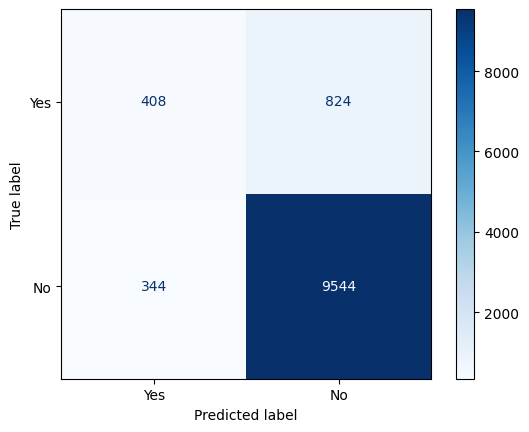


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      9888
           1       0.54      0.33      0.41      1232

    accuracy                           0.89     11120
   macro avg       0.73      0.65      0.68     11120
weighted avg       0.88      0.89      0.88     11120

348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


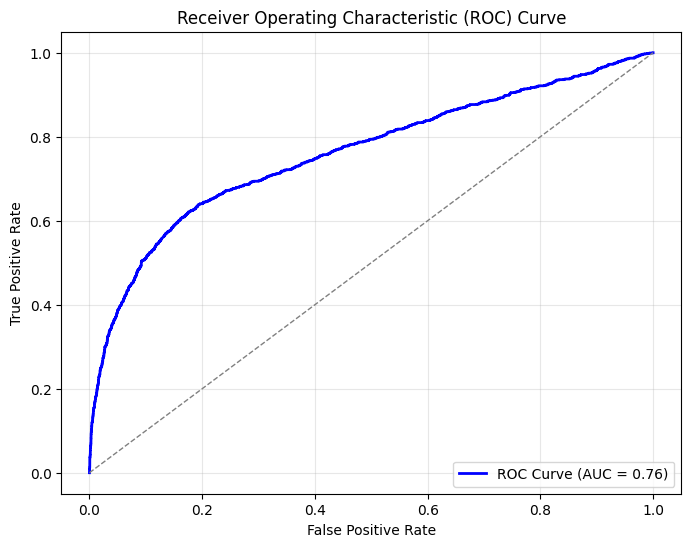

In [94]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to the training set only
ros = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


best_model = build_model(0.2, 0.01, 64)

best_model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=128, verbose=0)

# Generate predictions on the test set
y_pred = best_model.predict(X_test)  # For probabilities
y_pred_classes = (y_pred > 0.5).astype(int)  # probabilities to class labels

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes, labels=[1, 0])

# Display confusion matrix
print("\nConfusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Yes", "No"])
disp.plot(cmap=plt.cm.Blues)
plt.savefig('NNSOSCM.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes,zero_division=1))

# ROC Curve and AUC
y_pred_prob = best_model.predict(X_test).ravel()  # Get predicted probabilities for positive class
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig('NNSOSROC.png')
plt.show()